## Implementation of Distributed k-Means Clustering on General Topologies

### Introduction
In the era of big data, centralized algorithms like k-means and k- medians need to be scaled to distributed settings. Since we cannot transfer the whole dataset from each node to centralized node, we define ϵ-coreset. Transfering just the ϵ-coresets save a considerable amount of communication cost.

### ϵ-coreset:
An ϵ-coreset is a weighted set of points whose cost on any set of centers is approximately
the cost of the original data on those same centers up to accuracy ϵ. 

### Methodology 
* The dataset is distributed on several nodes in an undirected connected graph.
* A local constant approximation solution is computed 
* The total cost of local solution communicated to the other nodes in the graph using a message passing algorithm. 
* Based on the cost of nodes and the contribution of the data towards their local solution, the local data are sampled to form local coresets
* The message passing algorithm is called once again to combine the local coresets. 
* If each node constructs an ϵ-coreset on its local data, then the union of these local coresets is an ϵ-coreset for the entire data. 
* The constant approximation algorithm is applied to this global coreset to obtain the final result.





### Following is the illustration of the Distributed Coreset Construction, Message Passing and Distributed Clustering algorithm:

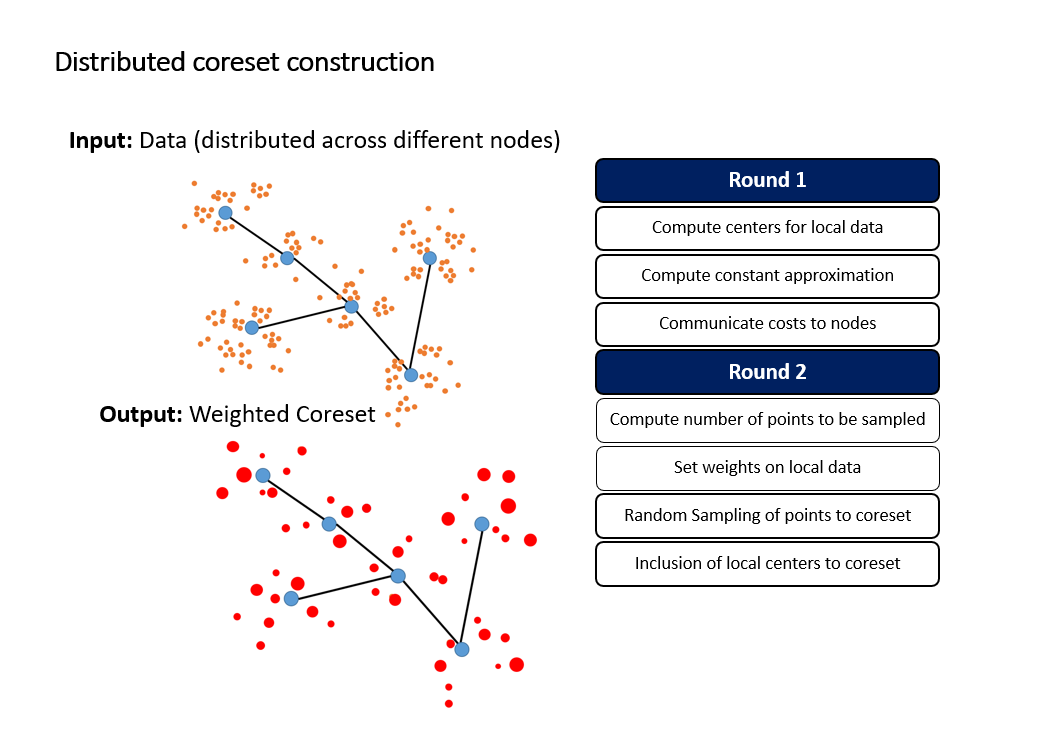

In [3]:
import IPython
IPython.display.Image("DistributedAlgo.png")

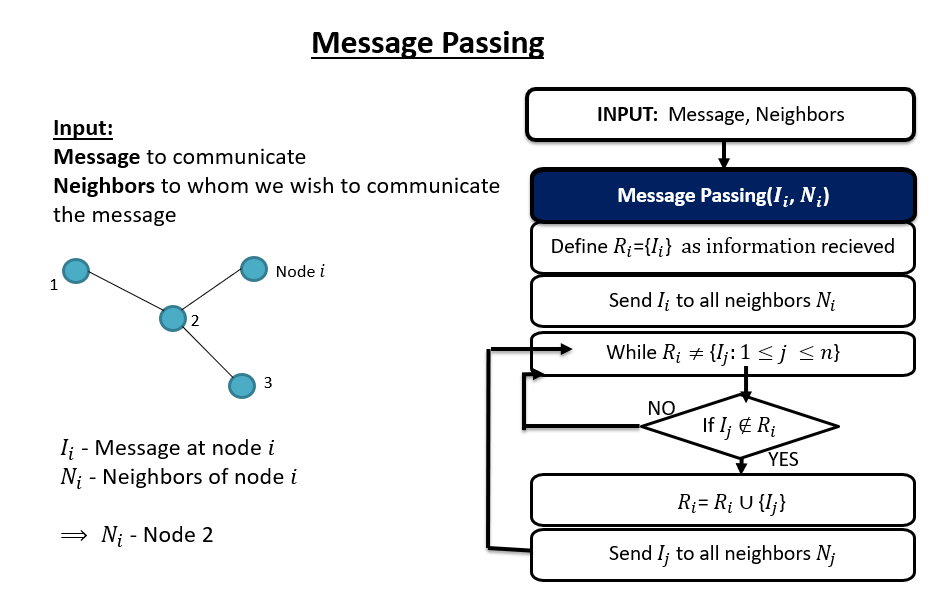

In [4]:
IPython.display.Image("MessageAlgo.png")

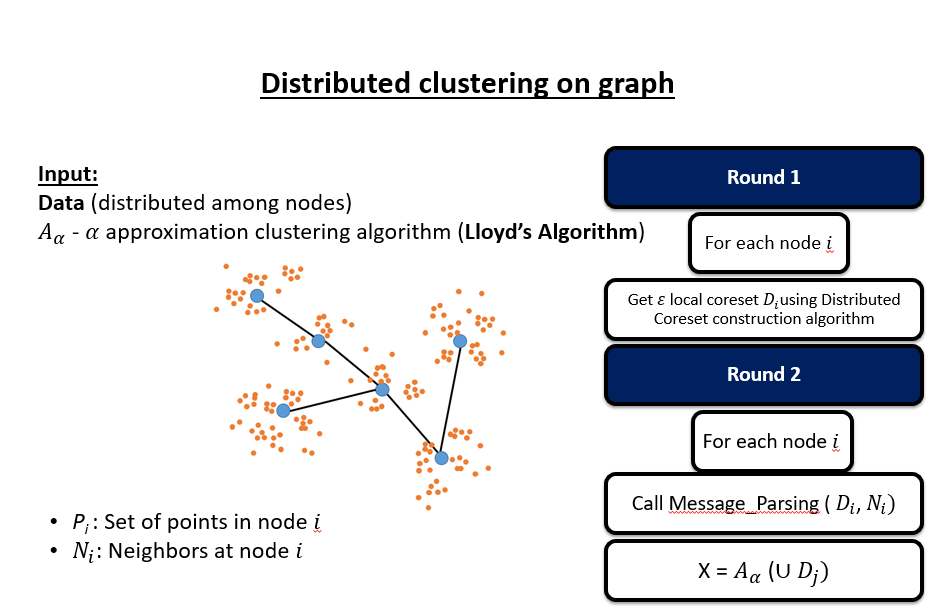

In [5]:
IPython.display.Image("ClusteringAlgo.png")

In [231]:
#Importing Packages
import math
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [254]:
# Node of the graph
class Node(object):
    def __init__(self,neighbors,degree):
        self.neighbors = neighbors
        self.degree = degree
        self.data = None                       #Holds the local data Pi
        self.centers = None                    #Holds the centers Bi
        self.local_coreset = None              #To store coreset, i.e. Si U Ai
        self.weights = None                    #To store the weight of points in local coreset Si U Ai
        self.message_received = {}
        self.X = None                          #To store the final centers
        self.cost_of_each_data = None
    def set_data(self,data):
        self.data = data
    def set_centers(self,centers):
        self.centers = centers
    def set_cost_of_each_data(self, c):
        self.cost_of_each_data = c
    def set_local_coreset(self,S):
        self.local_coreset = S
    def set_weights(self,weights):
        self.weights = weights
    def set_X(self,X):
        self.X = X
        
c_cost = np.zeros(8)
k_means_cost = np.zeros(8)
communication_cost=0.

In [255]:
#Types of graphs 
def create_random_graph(no_of_nodes,probability):
    G = nx.erdos_renyi_graph(no_of_nodes,probability)
    if nx.is_connected(G):
        1
    else:
        G = create_random_graph(no_of_nodes,probability)
    return G

def create_preferential_graph(n,m):
    # n = number of nodes, m = number of edges
    G = nx.generators.random_graphs.barabasi_albert_graph(n,m)
    if nx.is_connected(G):
        1
    else:
        G = create_preferential_graph(n,m)
    return G

def create_grid_graph(n,m):
    return nx.grid_2d_graph(n,m)

In [256]:
#Function to get sequence of iterating the nodes
#Returns 'nodes' used in fuction arguements later in message passing
def node_sequence(G):
    seq=[]
    l = list(nx.dfs_edges(G,0))
    for i in range(len(l)-1):
        if (l[i][1] == l[i+1][0]):
            seq.append(l[i][0])
        else:
            seq.append(l[i][0])
            seq.append(l[i][1])
            p = nx.shortest_path(G,l[i][1],l[i+1][0])
            for k in range(1,len(p)-1):
                seq.append(p[k])
    seq.append(l[-1][0])
    seq.append(l[-1][1])
    return seq

In [257]:
#Types of partitioning 
def uniform_partitioning(df,nodes):
    temp_df = df.copy(deep=True)
    size_of_pi = math.floor(df.shape[0]/len(nodes))
    for node in nodes:
        if node != nodes[-1]:
            node_dict[node].data = temp_df.sample(size_of_pi)
            temp_df.drop(node_dict[node].data.index,inplace = True)
        else:
            node_dict[node].data = temp_df
    return
            
def similarity_partitioning(df,nodes):
    temp_df = df.copy(deep=True)
    spec=SpectralClustering(n_clusters=len(nodes), gamma=1.0)
    c_id = spec.fit_predict(temp_df)
    for i in range(len(nodes)):
        node_dict[nodes[i]].data = temp_df[c_id==i]      
    return

def weighted_partitioning(df,nodes):
    temp_df = df.copy(deep=True)
    s = np.random.normal(0,1, len(nodes))
    s = (abs(s)/ np.sum(abs(s)))*temp_df.shape[0]
    
    for i in range(len(nodes)):
        if nodes[i] != nodes[-1]:
            node_dict[nodes[i]].data = temp_df.sample(int(round(s[i],0)))
            temp_df.drop(node_dict[nodes[i]].data.index,inplace = True)
        else:
            node_dict[nodes[i]].data = temp_df
    return

def degree_partitioning(df,nodes):
    temp_df = df.copy(deep=True)
    s=[]
    
    for node in nodes:
        #print (G.degree(node))
        s.append(float(G.degree(node)))
    s = (s/np.sum(s))*temp_df.shape[0]
    #s = pd.DataFrame(s)
    for i in range(len(nodes)):
        if nodes[i] != nodes[-1]:
            node_dict[nodes[i]].data = temp_df.sample(round(s[i],0))
            temp_df.drop(node_dict[nodes[i]].data.index,inplace = True)
        else:
            node_dict[nodes[i]].data = temp_df
    return

In [258]:
#Distribured Clustering algorithm 
def clustering_algo( data, no_of_centers ):
    kmeans = KMeans(n_clusters=no_of_centers, init = 'random', random_state=0).fit(np.array(data))
    #init stands for initialization, i.e. how to get first set of centers. Default is k-means++. I went for random
    #random_state stands for the seed to generate random centers in the beginning. Kept it zero to get same centers everytime.
    #Remove if not required
    #The package uses LLoyd's algorithm
    return kmeans                        #this will contain all details about clusters


In [259]:
#Message Passing Algorithm 
def Message_Passing(message,neighbors,node):
    global communication_cost
    if node not in node_dict[node].message_received: 
        node_dict[node].message_received[node] = message
    for neighbor in neighbors:
        for i, message in node_dict[node].message_received.items():
            if i not in node_dict[neighbor].message_received:
                node_dict[neighbor].message_received[i] = message
                if type(message) == float:
                    communication_cost+=1
                else:
                    communication_cost += message.shape[0]*message.shape[1]
    return

In [260]:
# Cost of the algorithm
def get_cost( data, centers):
    distanceMatrix = euclidean_distances( data, centers )
    return pd.DataFrame(distanceMatrix).min(axis=1)

#Distributed coreset construction algorithm 
def distributed_coreset_construction( nodes, t, no_of_centers ):
    for node in list(set(nodes)):
        #print("Centers for local node "+ str(node) +" being found")
        node_dict[node].centers = pd.DataFrame(clustering_algo(node_dict[node].data, no_of_centers).cluster_centers_)   
        #this will contain centers stored in dataframe
        node_dict[node].centers.columns = node_dict[node].data.columns
        #print("Cost of each data point in node "+ str(node) +" being found")
        node_dict[node].cost_of_each_data = get_cost( node_dict[node].data, node_dict[node].centers)  
        #comes back as pandas series
        node_dict[node].cost_of_each_data.index = node_dict[node].data.index
    for node in nodes:
        #print("passing cost from node " + str(node) + "to its neighbors")
        Message_Passing(node_dict[node].cost_of_each_data.sum(),node_dict[node].neighbors,node)
    #print("\n\nReverse message passing for costs begin\n")
    for node in list(reversed(nodes)):
        #print("passing cost from node " + str(node) + "to its neighbors")
        Message_Passing(node_dict[node].cost_of_each_data.sum(),node_dict[node].neighbors,node)
    #print("Message passing of costs done\n\n")
    for node in list(set(nodes)):
        #print("calculating ti, m_p, S_i, w_q, w_b for node " + str(node))
        #print (t)
        t_i = int(math.floor((t*node_dict[node].message_received[node])/sum(node_dict[node].message_received.values())))
        m_p = 2*(node_dict[node].cost_of_each_data + 1e-31)
        m_p.index = node_dict[node].data.index
        S_i = node_dict[node].data.sample(n=t_i,weights=m_p)
        w_q = sum(node_dict[node].message_received.values())/(t*m_p[S_i.index])
        w_b = []
        for index, b in node_dict[node].centers.iterrows():
            #print("finding points belonging to center " + str(index) + "for node " + str(node))
            temp_cost = get_cost(node_dict[node].data,b)   #cost of each data point from b
            temp_cost.index = node_dict[node].data.index
            Pb = node_dict[node].data[temp_cost == node_dict[node].cost_of_each_data]  
            #previous line measures euc dist of each point with center b and compares the values with min cost i.e.min d(p,X)over all x belonging to X
            #Pb will be a dataframe
            w_b.append(Pb.shape[0] - sum(w_q[S_i.index.intersection(Pb.index)]))
        node_dict[node].message_received = {}
        node_dict[node].set_local_coreset(pd.concat([S_i,node_dict[node].centers]))
        node_dict[node].set_weights(w_q.append(pd.Series(w_b)))
        #print("local coreset for node "+str(node)+" created\n")
    return


In [261]:
#Distributed clustering on graph algorithm 
def distributed_clustering_on_graph(nodes, t, no_of_centers):
    #print (t)
    #print("Process begun\n")
    distributed_coreset_construction( nodes, t, no_of_centers )
    #print("Coresets for all nodes created\n\n")
    for v_i in nodes:
        #print("Passing local coreset of node "+str(v_i)+" to its neighbors")
        Message_Passing(node_dict[v_i].local_coreset,node_dict[v_i].neighbors,v_i)
    #print("Forward passing of coresets done. \n Reverse passing begins: \n")
    for v_i in list(reversed(nodes)):
        #print("Passing coreset of node " + str(v_i) + " to its neighbors")
        Message_Passing(node_dict[v_i].local_coreset,node_dict[v_i].neighbors,v_i)
    #for v_i in list(set(nodes)):    
        #cluster_details = clustering_algo( pd.concat(list(node_dict[node].message_received.values())), no_of_centers )
        #node_dict[node].set_X(cluster_details)
    #print("Passing of local coresets completed\n\nClustering of global coreset begins")
    cluster_details = clustering_algo( pd.concat(list(node_dict[v_i].message_received.values())), no_of_centers )
    return(cluster_details)  #will return details about cluster generated

In [262]:
#print("begin")
n=4
m=3
G = create_random_graph(10,0.3)
#G = create_preferential_graph(n,m)
#G = create_grid_graph(n,m)
#Seelect one of the three


#print("Graph created")
nodes = node_sequence(G)
node_dict = {j:Node(G.neighbors(j),G.degree(j)) for j in G.nodes()}

#print("Node dictionary created")

df = pd.read_csv("letter-recognition.data", header = None )
df = df.fillna(0)
#df = np.transpose(df.fillna(0))
df = df.iloc[:,1:]
#print("dataframe read")

#uniform_partitioning(df,G.nodes())
#similarity_partitioning(df,G.nodes())
weighted_partitioning(df,G.nodes())
#degree_partitioning(df,G.nodes())
#Select one of the partitioning methods

#print("\ndata partitioning done")
t =   np.arange(0.1,0.8, 0.1)*df.shape[0]
#print (t)
no_of_centers = 2

for i in range(len(t)):
    for node in G.nodes():
        node_dict[node].centers = None                    #Holds the centers Bi
        node_dict[node].local_coreset = None              #To store coreset, i.e. Si U Ai
        node_dict[node].weights = None                    #To store the weight of points in local coreset Si U Ai
        node_dict[node].message_received = {}
        node_dict[node].X = None                          #To store the final centers
        node_dict[node].cost_of_each_data = None
    #print (t[i])
    
    cluster_details  = distributed_clustering_on_graph(nodes, t[i], no_of_centers)
    #This is to get the euclidean distance of the original data from the centers obtained from coresets
    #pd.DataFrame(euclidean_distances( df , cluster_details.cluster_centers_ )).min(axis=1).sum()
    #This is the communication cost
    #print (communication_cost)
    c_cost[i]=communication_cost
    #This is a centralised version of k means
    centralised_cluster = KMeans(n_clusters=no_of_centers, init = 'random', random_state=0).fit(np.array(df))
    #This is euclidean distance of original data from coreset centers divided by the euclidean distance of original data from centralised centers
    k_means_cost[i]=pd.DataFrame(euclidean_distances( df , cluster_details.cluster_centers_ )).min(axis=1).sum()/pd.DataFrame(euclidean_distances( df , centralised_cluster.cluster_centers_)).min(axis=1).sum()

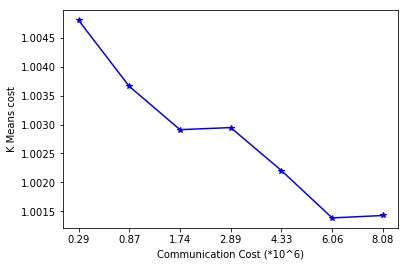

In [263]:
#Communication cost versus K means cost graph 
c_cost = c_cost[:-1]
k_means_cost = k_means_cost[:-1]
fig11 = plt.figure()
plt.xlabel('Communication Cost (*10^6)')
plt.plot(np.arange(len(c_cost)),list(k_means_cost),'*-b')

plt.xticks(np.arange(len(c_cost)),list(np.round(c_cost/10**6,2)))
plt.ylabel('K Means cost')
#plt.title('Color Histogram dataset, Random graph with weight Partitioning ')
plt.show()
fig11.savefig('Project(2)/Letter/spam_random_degree1.png')       


In [264]:
#This is to get the euclidean distance of the original data from the centers obtained from coresets
pd.DataFrame(euclidean_distances( df , cluster_details.cluster_centers_ )).min(axis=1).sum()
#This is the communication cost
print (' Communication cost is', communication_cost)

 Communication cost is 8080326.0


In [265]:
#This is a centralised version of k means
centralised_cluster = KMeans(n_clusters=no_of_centers, init = 'random', random_state=0).fit(np.array(df))

In [266]:
#This is euclidean distance of original data from coreset centers divided by the euclidean distance of original data from centralised centers
print ('Euclidean distance is', pd.DataFrame(euclidean_distances( df , cluster_details.cluster_centers_ )).min(axis=1).sum()/pd.DataFrame(euclidean_distances( df , centralised_cluster.cluster_centers_)).min(axis=1).sum())

Euclidean distance is 1.0014293353424015
